# Gaussian Processes

In [511]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

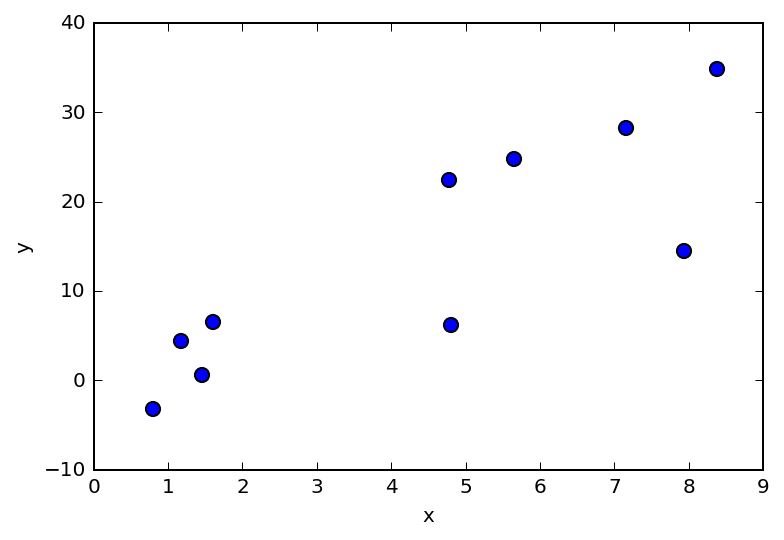

In [852]:
# Defining Data
n = 10
a = 3
b = .5
sigma = 5
X = np.random.uniform(0, 10, n)
y_obs = a*X + b + np.random.normal(0, sigma, n)
data = pd.DataFrame(np.array([X, y_obs]).T, columns=['x', 'y'])
data.plot(x='x', y='y', kind='scatter', s=50);

### Drawing samples from prior over functions

In [853]:
# Using squared exponential covariance function
def C(Xs, s, b):
    diff = squareform(pdist(Xs.reshape(len(Xs),1), 'euclidean'))
    return np.around(b*np.exp(-np.power(diff/s, 2)), 16)

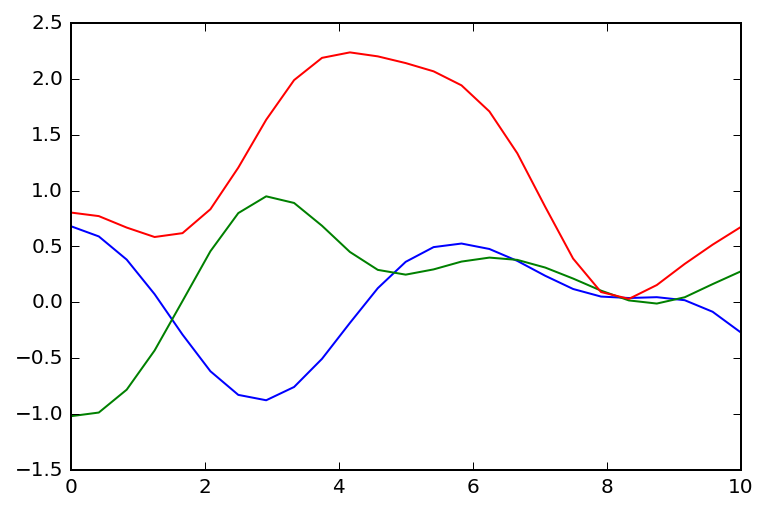

In [854]:
s = 2
b = 1

N = 25
ys = []
x_ = np.linspace(0, 10, N)

for f in range(3):
    y = np.random.multivariate_normal(np.zeros(len(x_)), C(x_,s,b))
    ys.append(y)
    
for y in ys:
    plt.plot(x_, y)

** :: NOTE ::**

Constructing squared exponential covariance kernel over a large number of points **will** produce an ill-conditioned covariance matrix

Condition Number of C(x,x'): 37083057649982592.00


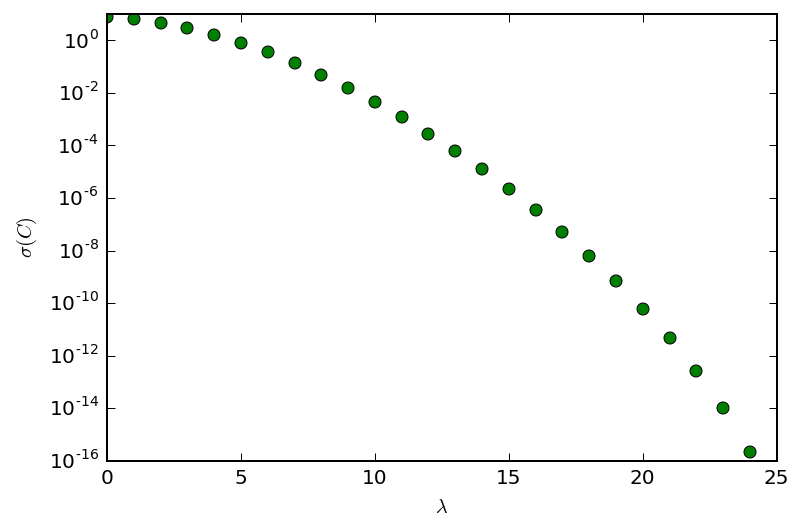

In [855]:
s = 2 
b = 1
C_eigvals = np.linalg.eigvals(C(x_, s, b))
plt.plot(range(len(C_eigvals)), C_eigvals, 'go');
plt.xlabel("$\lambda$")
plt.ylabel("$\sigma(C)$")
plt.yscale('log')
print "Condition Number of C(x,x'): %.2f" % (max(C_eigvals)/min(C_eigvals))

### Updating prior based on observations.

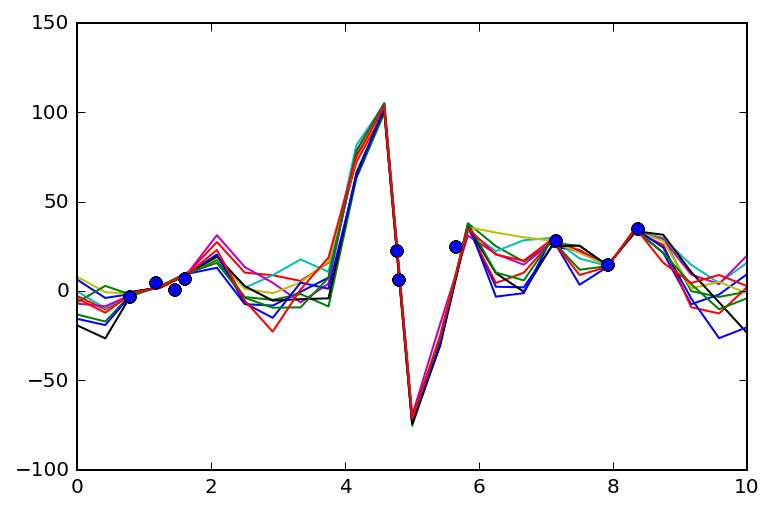

In [861]:
s = .5
b = 100
x_ = np.linspace(0,10,N)
Xhat = np.hstack([X, x_])
ys = []

for f in range(10):
    K = C(Xhat, s, b)
    mean = K[n:,:n].dot(np.linalg.inv(K[:n, :n])).dot(y_obs)
    var = K[n:,n:] - K[n:,:n].dot(np.linalg.inv(K[:n, :n])).dot(K[:n, n:])
    y = np.random.multivariate_normal(mean, var)
    ys.append(y)
    
for y in ys:
    plt.plot(x_, y)
    plt.plot(X, y_obs, 'bo')

### Accounting for stochasticity in observations

In [862]:
# Estimating hyperparameters of covariance function.
# Using a stochastic grid-search Nelder-Mead optimization strategy
# where our objective is -log[P(y|x)].

# Generally this is not an optimal strategy as we can calculate
# the gradient with respect to this objective and thus utilize
# more powerful optimization algorithms.

def log_y_marginal(theta):
    sigma_eye = theta[2]* np.eye(10)
    K_y = C(X, theta[0], theta[1]) + sigma_eye
    return -.5*(y_obs.T.dot(np.linalg.inv(K_y)).dot(y_obs) +
               np.log(np.linalg.det(K_y)))

nll = lambda theta: -log_y_marginal(theta)

seed_size = 50
seeds = [np.array([t1, t2 , 1]) for t1, t2 in 
         zip(np.random.uniform(.5,1000,seed_size), np.random.uniform(.5,1000,seed_size))]

opt_theta = np.ones(3)
for init in seeds:
    res = minimize(nll, init, method='Nelder-Mead')
    if nll(res.x) < nll(opt_theta):
        opt_theta = res.x

In [863]:
nll(opt_theta)

28.481892983020352

In [864]:
opt_theta

array([  -9.51219328,  403.61387988,   54.84339846])

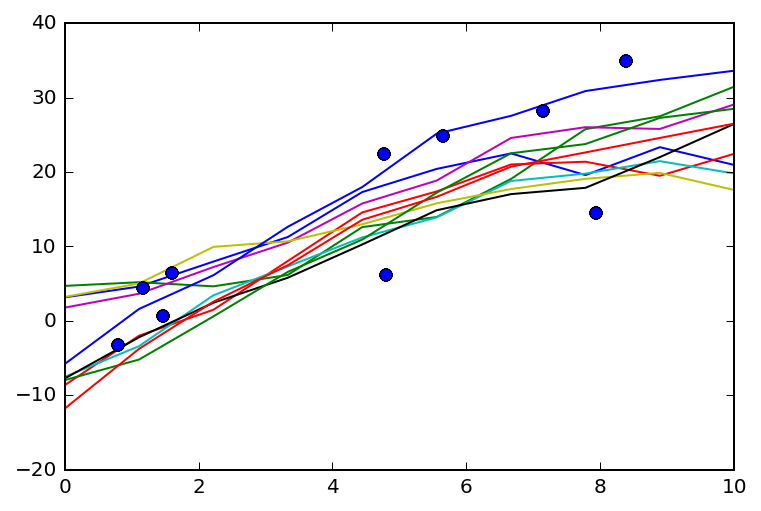

In [865]:
s, b, sigma = opt_theta
N = 10
x_ = np.linspace(0,10,N)
Xhat = np.hstack([X, x_])
ys = []
sigma_eye = np.eye(len(Xhat))*np.append(sigma*np.ones(n), np.ones(N))

for f in range(10):
    K = C(Xhat, s, b) + sigma_eye
    mean = K[n:,:n].dot(np.linalg.inv(K[:n, :n])).dot(y_obs)
    var = K[n:,n:] - K[n:,:n].dot(np.linalg.inv(K[:n, :n])).dot(K[:n, n:])
    y = np.random.multivariate_normal(mean, var)
    ys.append(y)
    
for y in ys:
    plt.plot(x_, y)
    plt.plot(X, y_obs, 'bo')